# Import packages and defining helper function

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Defining Experimental Params

In [3]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


# The experiment 

## Initalisation used

In [4]:
config["operator_params"]["operator"] = "RandomOcclude"
config["operator_params"]["num_measurements"] = 200
config["estimator_params"]["initalisation"] = "random"

## Baseline of 0

In [5]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

## Repeat for different measurments

In [6]:
config["exp_params"]["batch_size"] = 100
dm = mnist_dataloader_test(config, path=path)

In [7]:
mse = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    mse.append((sum(error)/len(error)).cpu().detach())

100%|██████████| 15/15 [01:20<00:00,  5.37s/it]


In [8]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"

In [9]:
random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.use_gpu_for_discriminator()
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    random.append((sum(error)/len(error)).cpu().detach())

  0%|          | 0/15 [00:00<?, ?it/s]

make_gans


  7%|▋         | 1/15 [00:12<03:00, 12.87s/it]

make_gans


 13%|█▎        | 2/15 [00:26<02:51, 13.21s/it]

make_gans


 20%|██        | 3/15 [00:39<02:39, 13.28s/it]

make_gans


 27%|██▋       | 4/15 [00:53<02:26, 13.33s/it]

make_gans


 33%|███▎      | 5/15 [01:06<02:13, 13.38s/it]

make_gans


 40%|████      | 6/15 [01:19<02:00, 13.38s/it]

make_gans


 47%|████▋     | 7/15 [01:33<01:47, 13.38s/it]

make_gans


 53%|█████▎    | 8/15 [01:46<01:32, 13.27s/it]

make_gans


 60%|██████    | 9/15 [01:59<01:19, 13.26s/it]

make_gans


 67%|██████▋   | 10/15 [02:12<01:06, 13.29s/it]

make_gans


 73%|███████▎  | 11/15 [02:26<00:53, 13.33s/it]

make_gans


 80%|████████  | 12/15 [02:39<00:39, 13.12s/it]

make_gans


 87%|████████▋ | 13/15 [02:52<00:26, 13.22s/it]

make_gans


 93%|█████████▎| 14/15 [03:06<00:13, 13.37s/it]

make_gans


100%|██████████| 15/15 [03:19<00:00, 13.30s/it]


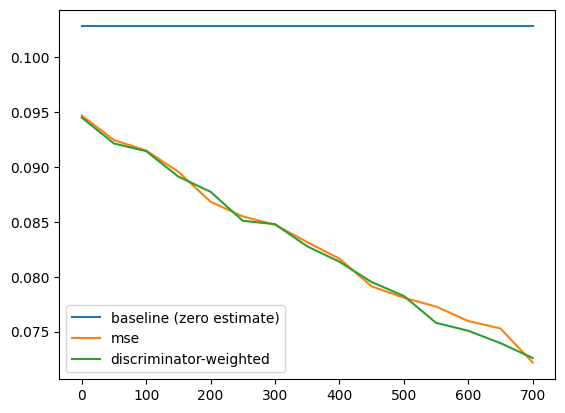

In [10]:
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.plot(list(range(0, 750, 50)), mse)
plt.plot(list(range(0, 750, 50)), random)
plt.legend(['baseline (zero estimate)','mse', 'discriminator-weighted'])
plt.show()